In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
# import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Inspect table schema
inspector = inspect(engine)
print(inspector.get_table_names())

pcrp_columns = inspector.get_columns('measurement')

print("measurement:")
for column in pcrp_columns:
    print(column['name'], column['type'])


['measurement', 'station']
measurement:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Find the most recent date in the data set.
conn = engine.connect()
data = engine.execute("SELECT MAX(date) FROM measurement;")
for record in data:
    print(record)

conn.close()

('2017-08-23',)


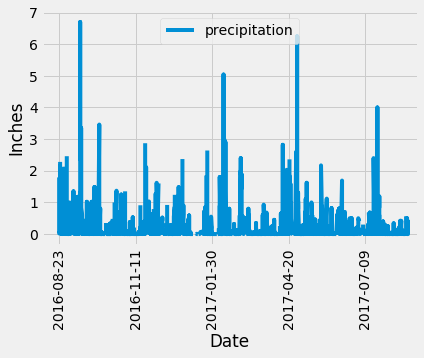

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
conn = engine.connect()

# Starting from the most recent data point in the database. 
latest_date = engine.execute("SELECT MAX(date) FROM measurement;").fetchall()[0][0]

# Convert str to datetime object
datetime_object = dt.datetime.strptime(latest_date, '%Y-%m-%d').date()

# Calculate the date one year from the last date in data set.
one_year_from_date = datetime_object - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
sql_statement = f"SELECT date, prcp FROM measurement WHERE Measurement.date BETWEEN '{one_year_from_date}' AND '{latest_date}';"

# Save the query results as a Pandas DataFrame. Explicitly set the column names
ytd_data_df = pd.read_sql(sql_statement, conn)

# Close connection
conn.close()

# Sort the dataframe by date
sorted_df = ytd_data_df.sort_values(by="date", ascending=True)
sorted_df = sorted_df.rename(columns={
    'prcp': 'precipitation'
})

# Use Pandas Plotting with Matplotlib to plot the data
x_axis = sorted_df['date']
y_axis = sorted_df['precipitation']
handle = plt.plot_date(x_axis, y_axis, xdate=True, fmt='-', label="precipitation")
plt.xticks(np.arange(0, len(x_axis), step=80),rotation=90)
plt.xlim(right=375)
plt.ylabel('Inches')
plt.xlabel("Date")
plt.legend(handles=handle, loc='upper center')
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
sorted_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Inspect table schema
inspector = inspect(engine)
print(inspector.get_table_names())

station_columns = inspector.get_columns('station')

print("station:")
for column in station_columns:
    print(column['name'], column['type'])

['measurement', 'station']
station:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [20]:
# Design a query to calculate the total number of stations in the dataset
conn = engine.connect()
total_stations = engine.execute("SELECT COUNT(DISTINCT measurement.station) FROM measurement;").fetchall()
print(total_stations)

conn.close()

[(9,)]


In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
conn = engine.connect()
total_activity_per_station = engine.execute("""
    SELECT DISTINCT station, 
        COUNT(*) OVER (PARTITION BY station) AS total_count
    FROM measurement
    ORDER BY total_count DESC;
""")

for record in total_activity_per_station:
    print(record)

conn.close()

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


##### Answer the following question: which station id has the greatest number of observations?
Station USC00519281 has the greatest number of observations at 2772.

In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
conn = engine.connect()
temps = engine.execute("""
SELECT
	MIN(tobs) AS min_temp,
	MAX(tobs) AS max_temp,
	AVG(tobs) AS avg_temp
FROM
	measurement
WHERE
	station = (
	SELECT
		station
	FROM
		(
		SELECT
			station,
			MAX(total)
		FROM
			(
			SELECT
				DISTINCT station,
				COUNT(*) OVER (PARTITION BY station) AS total
			FROM
				measurement)));
""").fetchall()

print(temps)

conn.close()

[(54.0, 85.0, 71.66378066378067)]


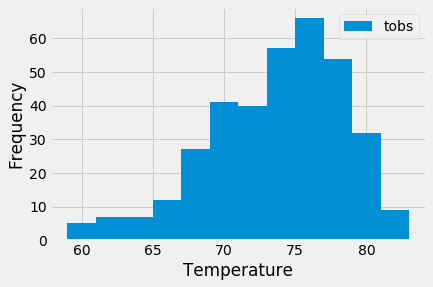

In [27]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
conn = engine.connect()

# Find most recent data point in the database for the most active station 
latest_date = engine.execute("""
SELECT
	MAX(date)
FROM
	(
	SELECT
		*
	FROM
		measurement
	WHERE
		station = (
		SELECT
			station
		FROM
			(
			SELECT
				station,
				MAX(total)
			FROM
				(
				SELECT
					DISTINCT station,
					COUNT(*) OVER (PARTITION BY station) AS total
				FROM
					measurement))));
""").fetchall()[0][0]

# Convert str to datetime object
datetime_object = dt.datetime.strptime(latest_date, '%Y-%m-%d').date()
# Calculate the date one year from the last date in data set.
one_year_from_date = datetime_object - dt.timedelta(days=365)

# Design a query to retrieve the last 12 months of precipitation data from the most active station
sql_statement = f"""
SELECT
	tobs
FROM
	measurement
WHERE
	station = (
	SELECT
		station
	FROM
		(
		SELECT
			station,
			MAX(total)
		FROM
			(
			SELECT
				DISTINCT station,
				COUNT(*) OVER (PARTITION BY station) AS total
			FROM
				measurement)))
	AND Measurement.date BETWEEN '{one_year_from_date}' AND '{latest_date}'
"""

# Run the query and read directly into pandas dataframe
most_active_df = pd.read_sql(sql_statement, conn)

# Close connection
conn.close()

# Use Pandas Plotting with Matplotlib to plot the data
plt.hist(most_active_df['tobs'], label='tobs', bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(loc="upper right")
plt.show()

# Close Session

In [18]:
# Close Session
session.close()